In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sn
import torch

# Importando dados

In [2]:
treino = torch.load("data/treino.pt")
teste = torch.load("data/teste.pt")

# Criando DataLoador

In [3]:

from torch.utils.data import Dataset, DataLoader

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtendo a imagem (vetor) e o rótulo (target) da linha idx do tensor
        image = self.data[idx, 1:-1]
        label = self.data[idx, -1].long()

        # Aplicando transformações, se necessário
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
dataset_treino = CustomDataset(treino)
dataset_teste = CustomDataset(teste)

## Treino

In [6]:
batch_size = 128  
train_dataloader = DataLoader(dataset_treino, batch_size=batch_size, shuffle=True)

## Teste

In [7]:
batch_size = 128  
test_dataloader = DataLoader(dataset_teste, batch_size=batch_size, shuffle=True)

## Visualizar dados

In [8]:
def visualizar_dataset(dataset):
    figure = plt.figure(figsize=(8, 8))
    rows, cols = 2, 2

    for i in range(1, 5):
        sample_idx = np.random.randint(len(dataset))
        img, label = dataset[sample_idx]

        image = img.numpy().reshape(100, 100)  
        titulo = "Boson" if label == 1 else "Ruido"

        figure.add_subplot(rows, cols, i)
        plt.imshow(image, interpolation='nearest', cmap='viridis')
        plt.title(titulo)
        plt.xlabel("$\\phi$")
        plt.ylabel("$\\eta$")
        plt.colorbar()

    plt.show()

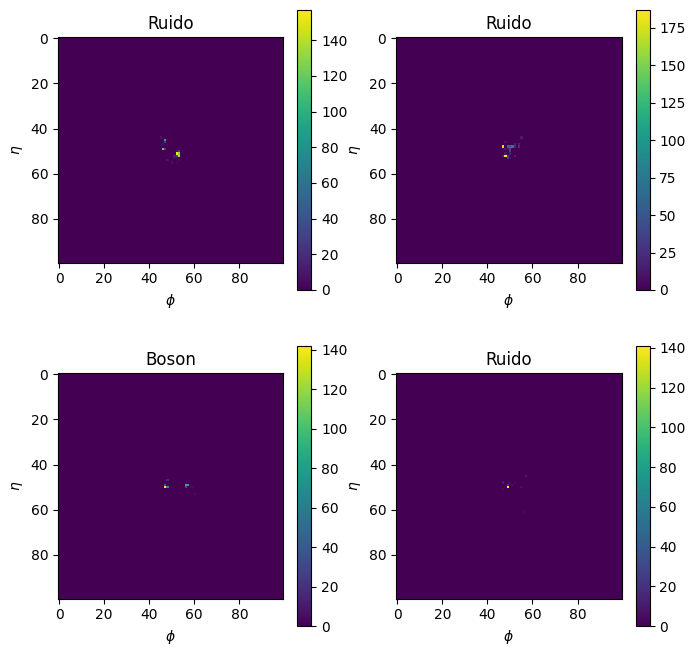

In [9]:
visualizar_dataset(dataset_treino)

# Modelo

In [10]:
from torch import nn

In [11]:
class MLPClassification(nn.Module):
  def __init__(self,entrada):
    super().__init__()


    self.layers = nn.Sequential(
        nn.Linear(entrada,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.layers(x)

In [12]:
entrada =(100*100)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
model = MLPClassification(entrada).to(device)

In [15]:
model

MLPClassification(
  (layers): Sequential(
    (0): Linear(in_features=10000, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# Otimizador

In [16]:
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
#lossfunction = nn.BCEWithLogitsLoss()
lossfunction = nn.BCELoss()

# Função Treino e Teste 

In [17]:
def train(modelo,dataloader,funcao_de_custo,otimizador):
  modelo.train() # esta praparado para ser treinado
  erro_acumulativo = 0.0
  for _, (data, target) in enumerate(dataloader):
    target, imgs =  target.float().to(device), data.to(device)

    pred = modelo(imgs)
    perda = funcao_de_custo(pred,target.unsqueeze(1).to(device))

    otimizador.zero_grad() # zero os gradientes acumulados
    perda.backward() #Calculo da gradiente
    otimizador.step() # anda para a direção de menos erro

    erro_acumulativo += perda.item()
  return erro_acumulativo/len(dataloader)


def test(modelo, dataloader, funcao_de_custo):
    modelo.eval()  
    total_acertos = 0
    total_exemplos = 0
    total_loss = 0.0

    with torch.no_grad():  
        for _, (data, target) in enumerate(dataloader):
            target, imgs = target.float().to(device), data.to(device)

            pred = modelo(imgs)
            loss = funcao_de_custo(pred, target.unsqueeze(1).to(device))

            # Arredonda as previsões para o valor mais próximo (0 ou 1)
            pred_labels = torch.round(pred)

            # Calcula o número de acertos
            total_acertos += (pred_labels == target.unsqueeze(1).to(device)).sum().item()
            total_exemplos += target.size(0)
            total_loss += loss.item()

    #accuracy = total_acertos / total_exemplos
    avg_loss = total_loss / len(dataloader)

    return  avg_loss

# Treinando

In [18]:
vezes_treinando = 300
train_losses = []
test_losses = []
for t in range(vezes_treinando):
  train_erro = train(model,train_dataloader,lossfunction,optimizer)
  train_losses.append(train_erro)
  if t %100 ==0:
    print(f"Epoca {t}; erro : {train_erro}")
  test_erro = test(model,test_dataloader,lossfunction)
  test_losses.append(test_erro)
print(f"erro : {test_erro}")

Epoca 0; erro : 0.481783229469897
Epoca 100; erro : 0.401723657877728
Epoca 200; erro : 0.39789572142624
erro : 0.3728842072804847


In [19]:
# Selecionando um exemplo específico do conjunto de dados de treinamento (por exemplo, o exemplo de índice 3)
example_index = 15
example_data, _ = dataset_teste[example_index]  # Ignorando o rótulo, pois não é necessário para a inferência

# Enviando o exemplo para o dispositivo (CPU ou GPU)
example_data = example_data.to(device)

# Passando o exemplo pelo modelo para obter a saída
output = model(example_data.unsqueeze(0))  # Usando unsqueeze para adicionar uma dimensão de lote (batch)

# A saída contém as previsões do modelo para o exemplo específico
print(output)


tensor([[0.5980]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [20]:
dataset_teste[15]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(0))

# Salvando modelo

In [21]:

caminho_arquivo = 'model/10_neuronios.pth'

# Salvar o modelo
torch.save(model.state_dict(), caminho_arquivo)

# Metricas de avaliação

## Curva ROC

In [22]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(modelo, dataloader):
    modelo.eval()  # Define o modelo para o modo de avaliação
    all_labels = []
    all_probs = []

    with torch.no_grad():  # Desliga o cálculo de gradientes para economizar memória e acelerar o processo
        for _, (data, target) in enumerate(dataloader):
            target, imgs = target.float().to(device), data.to(device)

            pred_probs = torch.sigmoid(modelo(imgs)).cpu().numpy()  # Probabilidades previstas pelo modelo
            all_probs.extend(pred_probs)
            all_labels.extend(target.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



### Teste

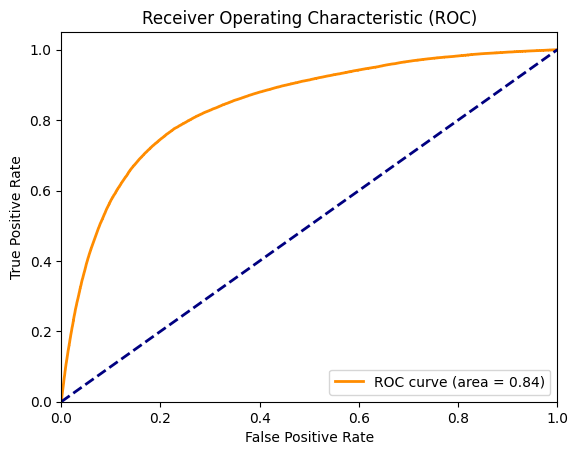

In [23]:
plot_roc_curve(model, test_dataloader)

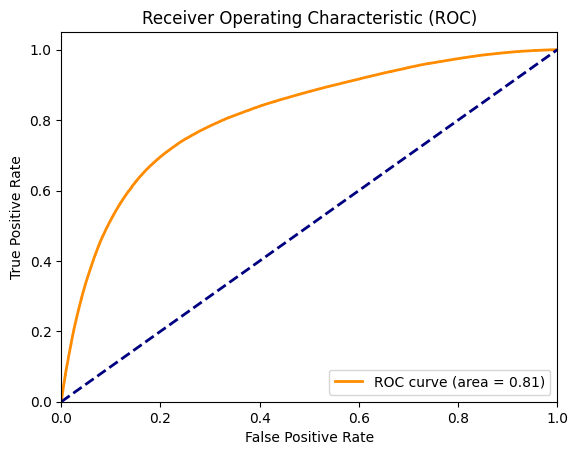

In [24]:
plot_roc_curve(model, train_dataloader)

# Matriz de confusão

In [25]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

In [26]:
classes = ["1","0"]
confusion_matrix = evaluate_accuracy(model, test_dataloader, classes)

Accuracy for class 1     is: 100.0 %
Accuracy for class 0     is: 0.0 %
Global acccuracy is 79.9


<Axes: >

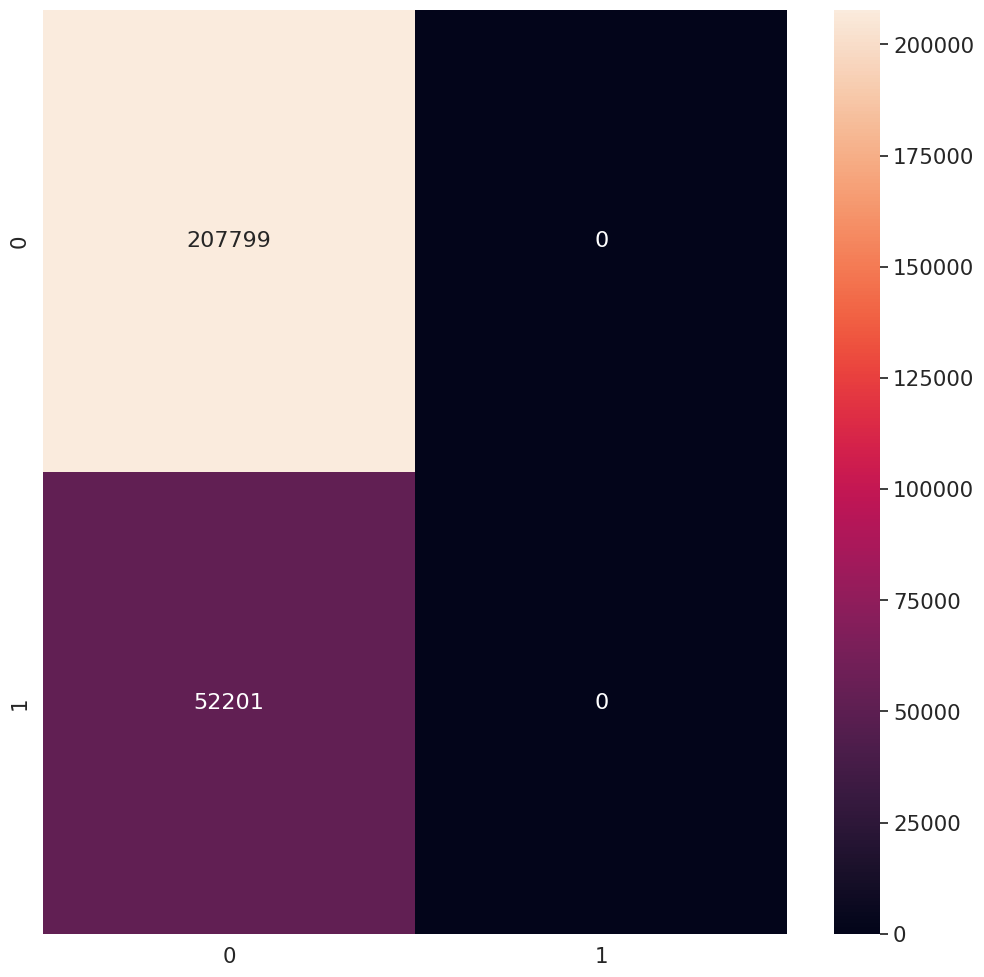

In [27]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')